Data Cleaning
- NaNlar çıkarıldı
- Empirical Novelty'ye "Not Applicable" yazan kişiler sanırım teorik buldukları için bu notu vermiş, onlara 0 verildi. (-1 verilmeli mi?)
- Ethics Flaglerde hem NO. hem Yes, .. yazanlar vardı. Bunlar aslında Yes demek istemiş, açıklamalar vardı, onlara Yes atandı.

Cevaplanabilecek Sorular
- Paper topic clustering (Halil)
    - Base: Pick top 30 topics based on frequency, then try to classify papers according to that. If 30 is not suitable, cut the topic clusses from the jumped class (RL: 5000 papers, Diffusion: 4000, Causality: 30) -> cut from Diffusion, but if we find things that we might use, we can add them later.
    - İnternette paper maps of neurips falan var onlar olabilir.
- Confidence yüksek ve recommendation yüksek olduğunda decision Reject ise, veya
- Confidence yüksek ve recommendation düşük olduğunda decision Accept ise area chair decision'ı ile reviewer decision'ı arasında discrepancy var mı?
- Hangi featurelar discrepancy ile correlated? (Temiz dataset ile yeni regression)
- Tanımladığımız metrikleri nasıl kullanabiliriz? (notion) (Yusuf)
- Review Length ile discrepancy ilişkisi nasıl? (Yusuf)
- Theoretical makalelerin discrepancy'si yüksek mi? (Not Applicaple)
- Süre ile discrepancy ilişkisi nasıl? (Büşra devam)

Cevaplanmış Sorular
- Son dakika submission yapan reviewerlar discrepancy yaratanlar mı? Hayır

Plot şeyleri (Büşra)
- Draw.io data feature map 2 data için de
- Base Data Cleaning ipynb

Data Science Resources: https://www.youtube.com/watch?v=SpZalI7nT0Q

In [1]:
import pandas as pd 
import numpy as np
import re
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
file_name = "../data/ICLR.cc-2023-Conference.csv"
df = pd.read_csv(file_name)

In [3]:
reviewer_feature_cols = [col.split('reviewer1_')[1] for col in df.columns if col.startswith('reviewer1')]
for i in reviewer_feature_cols:
    print(i)

recommendation
confidence
summary_of_the_paper
strength_and_weaknesses
clarity_quality_novelty_and_reproducibility
summary_of_the_review
correctness
technical_novelty_and_significance
empirical_novelty_and_significance
flag_for_ethics_review
length
cdate
tmdate


In [4]:
reviewer_cols = [col for col in df.columns for i in range(1, 5) if col.startswith('reviewer' + str(i) + '_')]
non_reviewer_cols = [col for col in df.columns if col not in reviewer_cols]

In [5]:
# Her papera bir row yerine her reviewa bir row olacak şekilde dataframe'i düzenleme

df['paper_no'] = np.arange(len(df))
review_df = pd.DataFrame(columns=['paper_id', 'reviewer', 'reviewer_recommendation', 'reviewer_confidence', 'reviewer_summary_of_the_paper', 'reviewer_strength_and_weaknesses', 'reviewer_clarity_quality_novelty_and_reproducibility', 'reviewer_summary_of_the_review', 'reviewer_correctness', 'reviewer_technical_novelty_and_significance', 'reviewer_empirical_novelty_and_significance', 'reviewer_flag_for_ethics_review', 'reviewer_length', 'reviewer_cdate', 'reviewer_tmdate', 'title', 'keywords', 'TL;DR', 'abstract', 'cdate', 'tmdate', 'decision'])
for idx, row in df.iterrows():
    for i in range(1, 5):
        dict_ = {}
        for col in reviewer_feature_cols:
            dict_['reviewer'] = i
            dict_['reviewer' + '_' + col] = row['reviewer' + str(i) + '_' + col]
        for col in non_reviewer_cols:
            dict_[col] = row[col]
        dict_['paper_id'] = row['paper_no']
        review_df.loc[len(review_df)] = dict_

In [6]:
df.head()

,title,keywords,TL;DR,abstract,cdate,tmdate,reviewer1_recommendation,reviewer1_confidence,reviewer1_summary_of_the_paper,reviewer1_strength_and_weaknesses,...,reviewer4_summary_of_the_review,reviewer4_correctness,reviewer4_technical_novelty_and_significance,reviewer4_empirical_novelty_and_significance,reviewer4_flag_for_ethics_review,reviewer4_length,reviewer4_cdate,reviewer4_tmdate,decision,paper_no
0,Guiding Safe Exploration with Weakest Precondi...,reinforcement learning; safe learning; safe ex...,"We use an online, weakest-precondition-based a...",In reinforcement learning for safety-critical ...,2022-09-22 14:36:24,2024-11-25 10:13:40,6: marginally above the acceptance threshold,"4: You are confident in your assessment, but n...",This paper deals with safe exploration in rein...,### Strength\n- Interesting and importance pro...,...,I like the proposed approach and its associate...,4: All of the claims and statements are well-s...,3: The contributions are significant and somew...,2: The contributions are only marginally signi...,NO.,3082.0,2022-11-03 08:08:39,2022-12-14 03:46:36,Accept: poster,0
1,An Adaptive Entropy-Regularization Framework f...,Multi-Agent Reinforcement Learning; Entropy Re...,This paper proposes an adaptive entropy-regul...,"In this paper, we propose an adaptive entropy-...",2022-09-22 14:33:17,2023-02-14 00:28:54,"3: reject, not good enough","4: You are confident in your assessment, but n...",This paper presents an MARL algorithm to adpat...,### Strengths\n\n1. This paper studies adaptiv...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reject,1
2,AutoSparse: Towards Automated Sparse Training,sparsity; sparse training; deep learning,NaN,Sparse training is emerging as a promising ave...,2022-09-22 14:32:39,2023-02-14 00:29:06,5: marginally below the acceptance threshold,"4: You are confident in your assessment, but n...",This paper first introduces a technique called...,Strengths:\n\n- Provided intuitive examples an...,...,1. The proposed method seems tricky and not el...,2: Several of the paper’s claims are incorrect...,2: The contributions are only marginally signi...,1: The contributions are neither significant n...,NO.,2254.0,2022-10-27 20:14:54,2022-10-27 20:14:54,Reject,2
3,Sampling is as easy as learning the score: the...,diffusion models; score-based generative model...,We prove that given an L2-accurate score estim...,We provide theoretical convergence guarantees ...,2022-09-22 14:40:10,2023-02-14 00:27:00,"8: accept, good paper","4: You are confident in your assessment, but n...",This paper examines the convergence of SGMs un...,Strength:\n\n- The presentation is clear.\n\n-...,...,Overall I think the paper introduces very stro...,3: Some of the paper’s claims have minor issue...,3: The contributions are significant and somew...,Not applicable,NO.,5316.0,2022-10-27 22:09:32,2022-10-27 22:09:32,Accept: notable-top-5%,3
4,RoCourseNet: Distributionally Robust Training ...,Counterfactual Explanation; Algorithmic Recour...,NaN,Counterfactual (CF) explanations for machine l...,2022-09-22 14:38:43,2024-11-25 10:12:40,"3: reject, not good enough","4: You are confident in your assessment, but n...",This submission proposed an approach to solvin...,Strength:\n\n1. The paper is easy to follow.\n...,...,The paper solves an important problem. The exp...,4: All of the claims and statements are well-s...,2: The contributions are only marginally signi...,2: The contributions are only marginally signi...,NO.,2937.0,2022-10-29 20:23:57,2022-10-29 20:23:57,Reject,4


### Time-to-Deadline - Discrepancy relation

In [7]:
df['reviewer1_cdate'] = pd.to_datetime(df['reviewer1_cdate'])
df['reviewer2_cdate'] = pd.to_datetime(df['reviewer2_cdate'])
df['reviewer3_cdate'] = pd.to_datetime(df['reviewer3_cdate'])
df['reviewer4_cdate'] = pd.to_datetime(df['reviewer4_cdate'])

df['reviewer1_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer1_cdate']
df['reviewer2_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer2_cdate']
df['reviewer3_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer3_cdate']
df['reviewer4_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer4_cdate']

In [8]:
df.dropna(subset=['reviewer1_cdate', 'reviewer2_cdate', 'reviewer3_cdate', 'reviewer4_cdate'], inplace=True)

In [9]:
df['reviewer1_recommendation'] = df['reviewer1_recommendation'].apply(lambda x: x.split(':')[0]).astype(int)
df['reviewer2_recommendation'] = df['reviewer2_recommendation'].apply(lambda x: x.split(':')[0]).astype(int)
df['reviewer3_recommendation'] = df['reviewer3_recommendation'].apply(lambda x: x.split(':')[0]).astype(int)
df['reviewer4_recommendation'] = df['reviewer4_recommendation'].apply(lambda x: x.split(':')[0]).astype(int)

In [10]:
df['max_recommendation'] = df[['reviewer1_recommendation', 'reviewer2_recommendation', 'reviewer3_recommendation', 'reviewer4_recommendation']].max(axis=1)
df['min_recommendation'] = df[['reviewer1_recommendation', 'reviewer2_recommendation', 'reviewer3_recommendation', 'reviewer4_recommendation']].min(axis=1)
df['max_min_recommendation_diff'] = df['max_recommendation'] - df['min_recommendation']

df['is_high_variance'] = df['max_min_recommendation_diff'] >= 4

In [11]:
df['decision'] = df['decision'].apply(lambda x: "Accept" if "accept" in x.lower() else "Reject")

In [12]:
df[df['decision'].eq("Accept") & df['is_high_variance']]

,title,keywords,TL;DR,abstract,cdate,tmdate,reviewer1_recommendation,reviewer1_confidence,reviewer1_summary_of_the_paper,reviewer1_strength_and_weaknesses,...,decision,paper_no,reviewer1_time_to_deadline,reviewer2_time_to_deadline,reviewer3_time_to_deadline,reviewer4_time_to_deadline,max_recommendation,min_recommendation,max_min_recommendation_diff,is_high_variance
32,PD-MORL: Preference-Driven Multi-Objective Rei...,multi-objective reinforcement learning; MORL; ...,A novel approach that obtains a single policy ...,Multi-objective reinforcement learning (MORL) ...,2022-09-22 14:37:04,2023-03-02 03:46:32,8,3: You are fairly confident in your assessment...,This work proposes an algorithm for solving mu...,The main strengths of this paper:\n- Novel app...,...,Accept,32,11 days 07:56:58,10 days 08:47:26,8 days 00:55:32,2 days 05:53:11,8,3,5,True
33,CircNet: Meshing 3D Point Clouds with Circumce...,Meshing; 3D Point Cloud; Point Cloud Triangula...,We present a deep neural architecture that det...,Reconstructing 3D point clouds into triangle m...,2022-09-22 14:34:26,2024-11-25 10:14:38,8,"4: You are confident in your assessment, but n...",This paper tackles the problem of point cloud ...,Strength\n+ The formulation of the problem as ...,...,Accept,33,15 days 11:46:51,13 days 09:18:49,0 days 01:53:56,-2 days +00:26:53,8,3,5,True
34,Semi-supervised learning with a principled lik...,Bayesian deep learning; Bayesian neural networ...,"We develop Bayesian semi-supervised learning, ...",We currently do not have an understanding of s...,2022-09-22 14:34:48,2023-02-21 09:35:10,5,"4: You are confident in your assessment, but n...",The authors consider the fact that our common ...,## Strengths\nThe paper is well argued for and...,...,Accept,34,16 days 15:04:34,10 days 04:45:05,10 days 01:48:15,7 days 20:28:22,8,3,5,True
37,Is Adversarial Training Really a Silver Bullet...,Data poisoning; adversarial training; indiscri...,We propose an indiscriminative feature-based p...,Indiscriminate data poisoning can decrease the...,2022-09-22 14:36:10,2023-03-02 17:30:28,6,"4: You are confident in your assessment, but n...",In this work the authors attack in models in t...,Strengths:\n* The method is novel and obtains ...,...,Accept,37,11 days 15:48:46,11 days 07:24:56,10 days 03:36:11,7 days 22:02:29,10,6,4,True
55,Red PANDA: Disambiguating Image Anomaly Detect...,Anomaly Detection; Disentanglement,Proposing a new anomaly detection setting when...,Anomaly detection methods strive to discover p...,2022-09-22 14:35:53,2023-03-02 12:44:02,6,3: You are fairly confident in your assessment...,This paper concerns anomaly detection. In part...,# Strengths\n* Anomaly detection is an interes...,...,Accept,55,15 days 13:28:45,9 days 21:32:44,8 days 18:47:58,4 days 10:41:23,6,1,5,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3678,DDM$^2$: Self-Supervised Diffusion MRI Denoisi...,Unsupervised MRI Denoising; Diffusion Models,NaN,Magnetic resonance imaging (MRI) is a common a...,2022-09-22 14:31:21,2024-11-25 10:16:17,1,5: You are absolutely certain about your asses...,The paper proposes a new method for denoising ...,Strengths\n\nThe proposed method makes use of ...,...,Accept,3678,10 days 21:33:32,10 days 13:51:50,3 days 20:27:53,3 days 11:06:24,8,1,7,True
3743,SeaFormer: Squeeze-enhanced Axial Transformer ...,NaN,NaN,"Since the introduction of Vision Transformers,...",2022-09-22 14:32:03,2024-11-25 10:15:52,8,"2: You are willing to defend your assessment, ...",this paper presents SeaFormer: a new transform...,Strength:\n- The proposed transformer is O(WH)...,...,Accept,3743,11 days 16:43:04,11 days 10:33:00,10 days 21:16:35,10 days 13:05:09,8,3,5,True
3746,Neural Image-based Avatars: Generalizable Radi...,Generalizable human radiance fields; Human per...,NaN,We present a method that enables synthesizing ...,2022-09-22 14:41:21,2024-11-25 10:11:30,8,3: You are fairly confident in your assessment...,The authors propose Neu

In [13]:
df[['reviewer1_recommendation', 'reviewer2_recommendation', 'reviewer3_recommendation', 'reviewer4_recommendation']]

,reviewer1_recommendation,reviewer2_recommendation,reviewer3_recommendation,reviewer4_recommendation
0,6,8,6,6
2,5,6,3,3
3,8,8,8,8
4,3,3,3,6
5,6,6,3,3
...,...,...,...,...
3789,6,6,6,6
3790,3,3,3,3
3792,1,6,6,3
3793,6,6,8,6


In [14]:
def custom_idx_min_time(row: pd.Series):
    min_val = row[['reviewer1_time_to_deadline', 'reviewer2_time_to_deadline', 'reviewer3_time_to_deadline', 'reviewer4_time_to_deadline']].min()
    min_val_str = ""
    for i in range(1, 5):
        if row['reviewer' + str(i) + '_time_to_deadline'] == min_val:
            min_val_str += str(i)

    return min_val_str

def custom_idx_min_rec(row: pd.Series):
    min_val = row[['reviewer1_recommendation', 'reviewer2_recommendation', 'reviewer3_recommendation', 'reviewer4_recommendation']].min()
    min_val_str = ""
    for i in range(1, 5):
        if row['reviewer' + str(i) + '_recommendation'] == min_val:
            min_val_str += str(i)

    return min_val_str

def custom_idx_max(row: pd.Series):
    max_val = row[['reviewer1_recommendation', 'reviewer2_recommendation', 'reviewer3_recommendation', 'reviewer4_recommendation']].max()
    max_val_str = ""
    for i in range(1, 5):
        if row['reviewer' + str(i) + '_recommendation'] == max_val:
            max_val_str += str(i)

    return max_val_str

In [15]:
df['min_time_to_deadline_index'] = df.apply(lambda x: custom_idx_min_time(x), axis=1)
df['min_recommendation_index'] = df.apply(lambda x: custom_idx_min_rec(x), axis=1)
df['max_recommendation_index'] = df.apply(lambda x: custom_idx_max(x), axis=1)

In [16]:
(100 * df[df['decision'].eq("Accept")]['min_recommendation_index'].value_counts(normalize=True)).round(2)

min_recommendation_index
3       13.54
2       12.91
4       12.18
1       11.73
1234     8.75
34       5.05
234      4.78
124      4.78
134      4.69
123      4.06
12       3.97
23       3.79
24       3.43
13       3.25
14       3.07
Name: proportion, dtype: float64

In [17]:
(100 * df[df['decision'].eq("Accept")]['max_recommendation_index'].value_counts(normalize=True)).round(2)
# burda son yükleyene bakıyoruz ama gerçekten geç kalmış mı diye bakmıyoruz

max_recommendation_index
1       12.09
3       11.46
4       10.65
2        9.39
1234     8.75
12       5.96
14       5.60
124      5.05
13       4.78
23       4.60
24       4.51
34       4.51
234      4.42
123      4.33
134      3.88
Name: proportion, dtype: float64

### Reviewer aggregation

In [18]:
review_df.columns

Index(['paper_id', 'reviewer', 'reviewer_recommendation',
       'reviewer_confidence', 'reviewer_summary_of_the_paper',
       'reviewer_strength_and_weaknesses',
       'reviewer_clarity_quality_novelty_and_reproducibility',
       'reviewer_summary_of_the_review', 'reviewer_correctness',
       'reviewer_technical_novelty_and_significance',
       'reviewer_empirical_novelty_and_significance',
       'reviewer_flag_for_ethics_review', 'reviewer_length', 'reviewer_cdate',
       'reviewer_tmdate', 'title', 'keywords', 'TL;DR', 'abstract', 'cdate',
       'tmdate', 'decision'],
      dtype='object')

In [19]:
review_df[['paper_id', 'reviewer', 'reviewer_correctness', 'reviewer_technical_novelty_and_significance', 'reviewer_empirical_novelty_and_significance', 'cdate', 'decision']]

,paper_id,reviewer,reviewer_correctness,reviewer_technical_novelty_and_significance,reviewer_empirical_novelty_and_significance,cdate,decision
0,0,1,2: Several of the paper’s claims are incorrect...,3: The contributions are significant and somew...,2: The contributions are only marginally signi...,2022-09-22 14:36:24,Accept: poster
1,0,2,4: All of the claims and statements are well-s...,3: The contributions are significant and somew...,3: The contributions are significant and somew...,2022-09-22 14:36:24,Accept: poster
2,0,3,4: All of the claims and statements are well-s...,3: The contributions are significant and somew...,2: The contributions are only marginally signi...,2022-09-22 14:36:24,Accept: poster
3,0,4,4: All of the claims and statements are well-s...,3: The contributions are significant and somew...,2: The contributions are only marginally signi...,2022-09-22 14:36:24,Accept: poster
4,1,1,2: Several of the paper’s claims are incorrect...,2: The contributions are only marginally signi...,2: The contributions are only marginally signi...,2022-09-22 14:33:17,Reject
...,...,...,...,...,...,...,...
15179,3794,4,2: Several of the paper’s claims are incorrect...,2: The contributions are only marginally signi...,2: The contributions are only marginally signi...,2022-09-22 14:35:28,Reject
15180,3795,1,3: Some of the paper’s claims have minor issue...,3: The contributions are significant and somew...,3: The contributions are significant and somew...,2022-09-22 14:30:24,Reject
15181,3795,2,3: Some of the paper’s claims have minor issue...,2: The contributions are only marginally signi...,3: The contributions are significant and somew...,2022-09-22 14:30:24,Reject
15182,3795,3,2: Several of the paper’s claims are incorrect...,3: The contributions are significant and somew...,2: The contributions are only marginally signi...,2022-09-22 14:30:24,Reject


<Axes: >

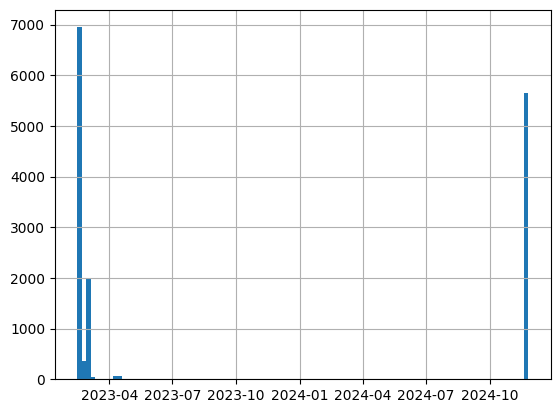

In [20]:
review_df['tmdate'] = pd.to_datetime(review_df['tmdate'])
review_df['tmdate'].hist(bins=100)

<Axes: >

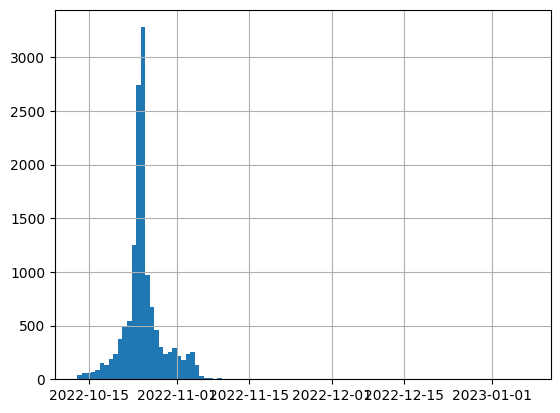

In [21]:
# Bizi ilgilendiren kısım burası
review_df['reviewer_cdate'] = pd.to_datetime(review_df['reviewer_cdate'])
review_df['reviewer_cdate'].hist(bins=100)

<Axes: >

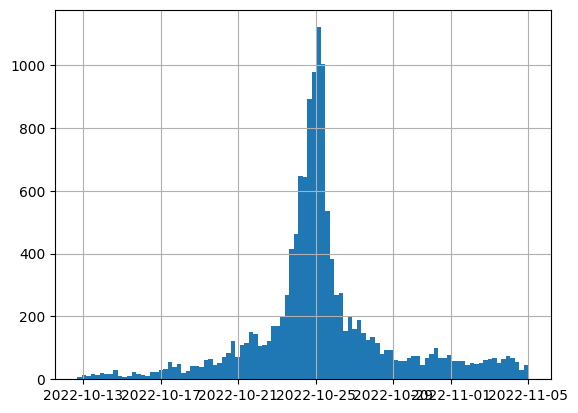

In [22]:
# Outlier eleyerek dağılımı daha iyi görebiliriz, 99. percentilin altındaki değerleri alalım
review_df[review_df['reviewer_cdate'] < review_df['reviewer_cdate'].quantile(0.99)]['reviewer_cdate'].hist(bins=100)

In [23]:
# ICLR deadline: 2022-11-05 01:00:00 --> Bu tarihten sonraki reviewları temizleyeceğiz
pd.set_option('display.max_colwidth', 100)
review_df[review_df['reviewer_cdate'] > pd.to_datetime('2022-11-05 01:00:00')].sort_values('reviewer_cdate')[['title']]

,title
10658,A Critical Analysis of Out-of-Distribution Detection for Document Understanding
14691,Improving Adversarial Robustness via Frequency Regularization
8867,Exploring semantic information in disease: Simple Data Augmentation Techniques for Chinese Disea...
7190,Orientation-Aware Graph Neural Networks for Protein Structure Representation Learning
1887,DEEPER-GXX: DEEPENING ARBITRARY GNNS
...,...
14387,Deep Class Conditional Gaussians for Continual Learning
10047,Enriching Online Knowledge Distillation with Specialist Ensemble
8015,Bias Amplification Improves Worst-Group Accuracy without Group Information
75,SciRepEval: A Multi-Format Benchmark for Scientific Document Representations


In [24]:
review_df_clean = review_df[review_df['reviewer_cdate'] < pd.to_datetime('2022-11-05 01:00:00')]
review_df_clean.dropna(subset=['reviewer_cdate'], inplace=True)

/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_77560/3800198529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean.dropna(subset=['reviewer_cdate'], inplace=True)


In [25]:
pd.set_option('display.max_columns', None)
review_df_clean.head(1)

,paper_id,reviewer,reviewer_recommendation,reviewer_confidence,reviewer_summary_of_the_paper,reviewer_strength_and_weaknesses,reviewer_clarity_quality_novelty_and_reproducibility,reviewer_summary_of_the_review,reviewer_correctness,reviewer_technical_novelty_and_significance,reviewer_empirical_novelty_and_significance,reviewer_flag_for_ethics_review,reviewer_length,reviewer_cdate,reviewer_tmdate,title,keywords,TL;DR,abstract,cdate,tmdate,decision
0,0,1,6: marginally above the acceptance threshold,"4: You are confident in your assessment, but not absolutely certain. It is unlikely, but not imp...",This paper deals with safe exploration in reinforcement learning in which an agent is required t...,### Strength\n- Interesting and importance problem formulation on safe exploration.\n- Unique ap...,### Clarity\nThis paper is mostly well-written and easy to follow.\n\n### Quality\nI have severa...,"Though this paper presents a new, promising method for an interesting problems, there are severa...",2: Several of the paper’s claims are incorrect or not well-supported.,3: The contributions are significant and somewhat new. Aspects of the contributions exist in pri...,2: The contributions are only marginally significant or novel.,NO.,3055.0,2022-10-20 09:40:48,2022-11-23 10:36:28,Guiding Safe Exploration with Weakest Preconditions,reinforcement learning; safe learning; safe exploration,"We use an online, weakest-precondition-based approach to ensure safety during exploration withou...","In reinforcement learning for safety-critical settings, it is often desirable for the agent to o...",2022-09-22 14:36:24,2024-11-25 10:13:40,Accept: poster


In [26]:
# Buraya bir analiz ve temizlik gerekebilir
# Hem NO hem YES demiş olanları YES yaptık, çünkü açıklamalar vardı
review_df_clean.value_counts('reviewer_flag_for_ethics_review')
review_df_clean['reviewer_flag_for_ethics_review'] = review_df_clean['reviewer_flag_for_ethics_review'].apply(lambda x: 1 if 'yes' in str(x).lower() else 0)

/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_77560/2666906590.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['reviewer_flag_for_ethics_review'] = review_df_clean['reviewer_flag_for_ethics_review'].apply(lambda x: 1 if 'yes' in str(x).lower() else 0)


In [27]:
# deadline'dan ne kadar önce review submitlenmiş ilk?
review_df_clean['time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - review_df_clean['reviewer_cdate']

/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_77560/1851927504.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - review_df_clean['reviewer_cdate']


In [28]:
# Buraya da bir temizlik gerekebilir
# Not Applicable olanlar genelde teorik olduğu için öyleymiş
print(review_df_clean['reviewer_empirical_novelty_and_significance'].value_counts())
review_df_clean['reviewer_empirical_novelty_and_significance'] = review_df_clean['reviewer_empirical_novelty_and_significance'].apply(lambda x: "0: Not Applicable" if x == "Not applicable" else x)
review_df_clean['reviewer_empirical_novelty_and_significance'].value_counts()

reviewer_empirical_novelty_and_significance
3: The contributions are significant and somewhat new. Aspects of the contributions exist in prior work.    5895
2: The contributions are only marginally significant or novel.                                              5270
Not applicable                                                                                              1075
4: The contributions are significant, and do not exist in prior works.                                      1018
1: The contributions are neither significant nor novel.                                                      621
Name: count, dtype: int64


/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_77560/896672030.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['reviewer_empirical_novelty_and_significance'] = review_df_clean['reviewer_empirical_novelty_and_significance'].apply(lambda x: "0: Not Applicable" if x == "Not applicable" else x)


reviewer_empirical_novelty_and_significance
3: The contributions are significant and somewhat new. Aspects of the contributions exist in prior work.    5895
2: The contributions are only marginally significant or novel.                                              5270
0: Not Applicable                                                                                           1075
4: The contributions are significant, and do not exist in prior works.                                      1018
1: The contributions are neither significant nor novel.                                                      621
Name: count, dtype: int64

In [29]:
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_columns', 10)

In [30]:
review_df_clean.reset_index(drop=True, inplace=True)

In [31]:
review_df_clean['review_confidence'] = review_df_clean['reviewer_confidence'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_confidence'], inplace=True)

review_df_clean['review_recommendation'] = review_df_clean['reviewer_recommendation'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_recommendation'], inplace=True)

review_df_clean['review_correctness'] = review_df_clean['reviewer_correctness'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_correctness'], inplace=True)

review_df_clean['review_technical_novelty_and_significance'] = review_df_clean['reviewer_technical_novelty_and_significance'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_technical_novelty_and_significance'], inplace=True)

review_df_clean['review_empirical_novelty_and_significance'] = review_df_clean['reviewer_empirical_novelty_and_significance'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_empirical_novelty_and_significance'], inplace=True)

/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_77560/281507201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['review_confidence'] = review_df_clean['reviewer_confidence'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_77560/281507201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean.drop(columns=['reviewer_confidence'], inplace=True)
/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_77560/281507201.py:4: SettingWith

In [32]:
review_df_clean.head()

,paper_id,reviewer,reviewer_summary_of_the_paper,reviewer_strength_and_weaknesses,reviewer_clarity_quality_novelty_and_reproducibility,...,review_confidence,review_recommendation,review_correctness,review_technical_novelty_and_significance,review_empirical_novelty_and_significance
0,0,1,This paper deals with safe exploration in rein...,### Strength\n- Interesting and importance pro...,### Clarity\nThis paper is mostly well-written...,...,4,6,2,3,2
1,0,2,This paper adapts ideas from formal program an...,# Strengths\n\nThe technique is well motivated...,The technique and motivation are clearly commu...,...,3,8,4,3,3
2,0,3,The paper proposes a method for safe reinforce...,+ The approach reduces the number of safety vi...,The paper is overall well written and presente...,...,3,6,4,3,2
3,0,4,"The paper proposes a safe RL algorithm, Symbol...",Strengths:\n* SPICE’s use of formal methods pr...,The paper is generally clear. I appreciate the...,...,4,6,4,3,2
4,1,1,This paper presents an MARL algorithm to adpat...,### Strengths\n\n1. This paper studies adaptiv...,The Clarity of this paper can definitely be im...,...,4,3,2,2,2


In [33]:
paper_df = review_df_clean.groupby('paper_id').agg({'time_to_deadline': ['std', 'mean'], 
                                                    'review_confidence': ['std', 'mean'],
                                                    'review_recommendation': ['std', 'mean', 'max', 'min'],
                                                    'review_correctness': ['std', 'mean'],
                                                    'review_technical_novelty_and_significance': ['std', 'mean'],
                                                    'review_empirical_novelty_and_significance': ['std', 'mean'],
                                                    'reviewer': 'count',
                                                    'decision': 'first'}).reset_index()

In [34]:
pd.set_option('display.max_columns', None)
paper_df


paper_id          time_to_deadline                             \
                                    std                       mean   
0           0 5 days 19:16:10.689828726            9 days 14:20:49   
1           1 2 days 06:32:55.872867145 12 days 22:53:01.333333333   
2           2 1 days 12:54:38.117582429     9 days 09:35:52.250000   
3           3 2 days 13:20:58.514324593    11 days 04:09:52.500000   
4           4 5 days 09:23:30.024963235    12 days 02:20:32.750000   
...       ...                       ...                        ...   
3791     3791 5 days 23:13:08.435799653 16 days 11:16:41.666666666   
3792     3792 4 days 09:28:45.175281084    11 days 22:56:18.250000   
3793     3793 1 days 20:41:21.379731310    11 days 20:54:33.750000   
3794     3794 3 days 09:33:53.422118322     8 days 04:57:49.750000   
3795     3795 7 days 04:45:12.891550738           11 days 06:42:36   

     review_confidence           review_recommendation                    \
                   std      mean                   std      mean max min   
0             0.577350  3.500000              1.000000  6.500000   8   6   
1             0.577350  3.666667              2.516611  5.666667   8   3   
2             0.500000  4.750000              1.500000  4.250000   6   3   
3             0.500000  3.250000              0.000000  8.000000   8   8   
4             0.500000  3.750000              1.500000  3.750000   6   3   
...                ...       ...                   ...       ...  ..  ..   
3791          0.000000  4.000000              1.154701  3.666667   5   3   
3792          0.816497  3.000000              2.449490  4.000000   6   1   
3793          0.577350  3.500000              1.000000  6.500000   8   6   
3794          0.000000  4.000000              1.500000  3.750000   6   3   
3795          0.000000  4.000000              0.577350  5.666667   6   5   

     review_correctness           review_technical_novelty_and_significance  \
                    std      mean                                       std   
0              1.000000  3.500000                                  0.000000   
1              1.154701  3.333333                                  1.000000   
2              0.500000  2.750000                                  0.816497   
3              0.577350  3.500000                                  0.577350   
4              0.577350  3.500000                                  0.000000   
...                 ...       ...                                       ...   
3791           0.577350  3.333333                                  0.577350   
3792           1.290994  2.500000                                  0.500000   
3793           0.577350  3.500000                                  0.500000   
3794           0.816497  3.000000                                  0.577350   
3795           0.577350  2.666667                                  0.577350   

               review_empirical_novelty_and_significance           reviewer  \
          mean                                       std      mean    count   
0     3.000000                                  0.500000  2.250000        4   
1     3.000000                                  0.577350  2.333333        3   
2     2.000000                                  0.577350  1.500000        4   
3     3.500000                                  2.309401  2.000000        4   
4     2.000000                                  1.000000  1.500000        4   
...        ...                                       ...       ...      ...   
3791  2.666667                                  1.154701  0.666667        3   
3792  2.750000                                  1.000000  0.500000        4   
3793  2.250000                                  1.414214  2.000000        4   
3794  2.500000                                  0.577350  2.500000        4   
3795  2.666667                                  0.577350  2.666667        3   

                    decision  
                  

In [35]:
paper_df['review_recommendation', 'max_min_diff'] = paper_df['review_recommendation', 'max'] - paper_df['review_recommendation', 'min']

In [36]:
paper_df.head()

paper_id          time_to_deadline                             \
                                 std                       mean   
0        0 5 days 19:16:10.689828726            9 days 14:20:49   
1        1 2 days 06:32:55.872867145 12 days 22:53:01.333333333   
2        2 1 days 12:54:38.117582429     9 days 09:35:52.250000   
3        3 2 days 13:20:58.514324593    11 days 04:09:52.500000   
4        4 5 days 09:23:30.024963235    12 days 02:20:32.750000   

  review_confidence           review_recommendation                    \
                std      mean                   std      mean max min   
0           0.57735  3.500000              1.000000  6.500000   8   6   
1           0.57735  3.666667              2.516611  5.666667   8   3   
2           0.50000  4.750000              1.500000  4.250000   6   3   
3           0.50000  3.250000              0.000000  8.000000   8   8   
4           0.50000  3.750000              1.500000  3.750000   6   3   

  review_correctness           review_technical_novelty_and_significance       \
                 std      mean                                       std mean   
0           1.000000  3.500000                                  0.000000  3.0   
1           1.154701  3.333333                                  1.000000  3.0   
2           0.500000  2.750000                                  0.816497  2.0   
3           0.577350  3.500000                                  0.577350  3.5   
4           0.577350  3.500000                                  0.000000  2.0   

  review_empirical_novelty_and_significance           reviewer  \
                                        std      mean    count   
0                                  0.500000  2.250000        4   
1                                  0.577350  2.333333        3   
2                                  0.577350  1.500000        4   
3                                  2.309401  2.000000        4   
4                                  1.000000  1.500000        4   

                 decision review_recommendation  
                    first          max_min_diff  
0          Accept: poster                     2  
1                  Reject                     5  
2                  Reject                     3  
3  Accept: notable-top-5%                     0  
4                  Reject                     3

In [37]:
paper_df['is_high_variance'] = (paper_df['review_recommendation', 'max_min_diff'] >= 4).astype(int)

In [38]:
paper_df.head()

paper_id          time_to_deadline                             \
                                 std                       mean   
0        0 5 days 19:16:10.689828726            9 days 14:20:49   
1        1 2 days 06:32:55.872867145 12 days 22:53:01.333333333   
2        2 1 days 12:54:38.117582429     9 days 09:35:52.250000   
3        3 2 days 13:20:58.514324593    11 days 04:09:52.500000   
4        4 5 days 09:23:30.024963235    12 days 02:20:32.750000   

  review_confidence           review_recommendation                    \
                std      mean                   std      mean max min   
0           0.57735  3.500000              1.000000  6.500000   8   6   
1           0.57735  3.666667              2.516611  5.666667   8   3   
2           0.50000  4.750000              1.500000  4.250000   6   3   
3           0.50000  3.250000              0.000000  8.000000   8   8   
4           0.50000  3.750000              1.500000  3.750000   6   3   

  review_correctness           review_technical_novelty_and_significance       \
                 std      mean                                       std mean   
0           1.000000  3.500000                                  0.000000  3.0   
1           1.154701  3.333333                                  1.000000  3.0   
2           0.500000  2.750000                                  0.816497  2.0   
3           0.577350  3.500000                                  0.577350  3.5   
4           0.577350  3.500000                                  0.000000  2.0   

  review_empirical_novelty_and_significance           reviewer  \
                                        std      mean    count   
0                                  0.500000  2.250000        4   
1                                  0.577350  2.333333        3   
2                                  0.577350  1.500000        4   
3                                  2.309401  2.000000        4   
4                                  1.000000  1.500000        4   

                 decision review_recommendation is_high_variance  
                    first          max_min_diff                   
0          Accept: poster                     2                0  
1                  Reject                     5                1  
2                  Reject                     3                0  
3  Accept: notable-top-5%                     0                0  
4                  Reject                     3                0

In [39]:
paper_df['decision', 'first'] = paper_df['decision', 'first'].apply(lambda x: "Accept" if "accept" in x.lower() else "Reject")

In [40]:
# group the paper_df by ('decision', 'first') and get mean of 'is_high_variance'
paper_df.groupby(('decision', 'first'))['is_high_variance'].mean()

(decision, first)
Accept    0.125238
Reject    0.182636
Name: is_high_variance, dtype: float64

In [41]:
paper_df['time_to_deadline', 'mean'].head()

0              9 days 14:20:49
1   12 days 22:53:01.333333333
2       9 days 09:35:52.250000
3      11 days 04:09:52.500000
4      12 days 02:20:32.750000
Name: (time_to_deadline, mean), dtype: timedelta64[ns]

- Analysis of whether the distribution of the time until submission changes, we have observed that it has not.

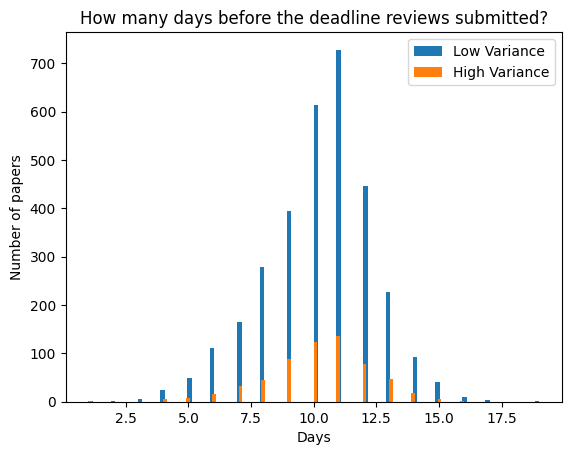

In [42]:
import matplotlib.pyplot as plt

plt.hist(paper_df[paper_df['is_high_variance'] == 0]['time_to_deadline', 'mean'].dt.days, bins=100, alpha=1, label='Low Variance')
plt.hist(paper_df[paper_df['is_high_variance'] == 1]['time_to_deadline', 'mean'].dt.days, bins=100, alpha=1, label='High Variance')

plt.legend(loc='upper right')

plt.xlabel("Days")
plt.ylabel("Number of papers")

plt.title("How many days before the deadline reviews submitted?")
plt.show()


In [43]:
review_df.groupby('paper_id').count().sort_values('reviewer', ascending=False).head()

,reviewer,reviewer_recommendation,reviewer_confidence,reviewer_summary_of_the_paper,reviewer_strength_and_weaknesses,reviewer_clarity_quality_novelty_and_reproducibility,reviewer_summary_of_the_review,reviewer_correctness,reviewer_technical_novelty_and_significance,reviewer_empirical_novelty_and_significance,reviewer_flag_for_ethics_review,reviewer_length,reviewer_cdate,reviewer_tmdate,title,keywords,TL;DR,abstract,cdate,tmdate,decision
paper_id,,,,,,,,,,,,,,,,,,,,,
0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2536,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,0,4,4,4,4
2524,4,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4
2525,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2526,4,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,0,4,4,4,4


## OLD ANALYSIS

In [44]:


# 1. Import Necessary Libraries
# 2. Load the CSV Data
# Replace 'reviews.csv' with your actual CSV file path if different
# 3. Extract Numerical Features

# a. Define a helper function to extract numerical prefixes
def extract_numeric_prefix(s):
    """
    Extracts the leading integer from a string.
    If no integer is found, returns NaN.
    """
    match = re.match(r'^(\d+)', str(s).strip())
    return int(match.group(1)) if match else np.nan

# b. List of reviewers
reviewers = ['reviewer1', 'reviewer2', 'reviewer3', 'reviewer4']

# c. Columns to extract numeric prefixes from
prefix_columns = [
    'recommendation',
    'confidence',
    'correctness',
    'technical_novelty_and_significance',
    'empirical_novelty_and_significance'
]

# d. Extract numerical prefixes for each reviewer and specified columns
for reviewer in reviewers:
    for col in prefix_columns:
        original_col = f'{reviewer}_{col}'
        new_col = f'{reviewer}_{col}_num'
        if original_col in df.columns:
            df[new_col] = df[original_col].apply(extract_numeric_prefix)
        else:
            # If the expected column is missing, create it with NaN
            df[new_col] = np.nan

# e. Convert Date Columns to Numerical Features
# General date columns
date_columns = ['cdate', 'tmdate']

# Reviewer-specific date columns
for reviewer in reviewers:
    date_columns.extend([f'{reviewer}_cdate', f'{reviewer}_tmdate'])

for col in date_columns:
    if col in df.columns:
        # Convert to datetime, coercing errors to NaT
        df[col] = pd.to_datetime(df[col], errors='coerce')
        
        # Option 1: Convert to timestamp (seconds since epoch)
        # Handle potential NaT by filling with 0 or another placeholder
        df[f'{col}_timestamp'] = df[col].astype(np.int64) / 1e9
        df[f'{col}_timestamp'] = df[f'{col}_timestamp'].replace([np.inf, -np.inf], np.nan)
        
        # Option 2: Extract date components
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
        df[f'{col}_hour'] = df[col].dt.hour
        df[f'{col}_minute'] = df[col].dt.minute
        df[f'{col}_second'] = df[col].dt.second

# f. Ensure Direct Numerical Columns are in Numeric Format
# For example: 'reviewer1_length', 'reviewer2_length', etc.
for reviewer in reviewers:
    length_col = f'{reviewer}_length'
    if length_col in df.columns:
        df[length_col] = pd.to_numeric(df[length_col], errors='coerce')

# 4. Handle Missing Values

# a. Identify all numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# b. Fill NaNs with the median of each numerical column
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# 5. Compute the Target Variable

# a. Extract numerical recommendation scores
recommendation_cols = [f'{reviewer}_recommendation_num' for reviewer in reviewers]

# b. Ensure recommendation columns exist
recommendation_cols = [col for col in recommendation_cols if col in df.columns]

# c. Compute variance across reviewers for each row
df['recommendation_variance'] = df[recommendation_cols].var(axis=1)
df['recommendation_difference'] = df[recommendation_cols].max(axis=1) - df[recommendation_cols].min(axis=1)

# 6. Prepare Features and Target

# a. Define target
target = 'recommendation_variance'

# b. Define feature columns
# Exclude original string columns and columns related to recommendations
excluded_columns = [
    'title', 'keywords', 'TL;DR', 'abstract', 'decision',
    'recommendation_variance'
]

# Additionally exclude original string-based reviewer columns
string_based_cols = []
for reviewer in reviewers:
    string_based_cols.extend([
        f'{reviewer}_recommendation',
        f'{reviewer}_confidence',
        f'{reviewer}_summary_of_the_paper',
        f'{reviewer}_strength_and_weaknesses',
        f'{reviewer}_clarity_quality_novelty_and_reproducibility',
        f'{reviewer}_summary_of_the_review',
        f'{reviewer}_flag_for_ethics_review',
        f'{reviewer}_cdate',
        f'{reviewer}_tmdate',
        f'{reviewer}_recommendation_num'
    ])
excluded_columns.extend(string_based_cols)

# Remove any excluded columns from numerical_cols
feature_cols = [col for col in numerical_cols if col not in excluded_columns]

feature_cols = []

for col in numerical_cols:
    if col not in excluded_columns:
        feature_cols.append(col)
        

# c. Prepare the feature matrix X and target vector y
X = df[feature_cols]
y = df[target]

/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_77560/1679916423.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_hour'] = df[col].dt.hour
/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_77560/1679916423.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_minute'] = df[col].dt.minute
/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_77560/1679916423.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

In [45]:
X.head()

,reviewer1_length,reviewer2_length,reviewer3_length,reviewer4_length,paper_no,reviewer1_time_to_deadline,reviewer2_time_to_deadline,reviewer3_time_to_deadline,reviewer4_time_to_deadline,max_recommendation,min_recommendation,max_min_recommendation_diff,reviewer1_confidence_num,reviewer1_correctness_num,reviewer1_technical_novelty_and_significance_num,reviewer1_empirical_novelty_and_significance_num,reviewer2_confidence_num,reviewer2_correctness_num,reviewer2_technical_novelty_and_significance_num,reviewer2_empirical_novelty_and_significance_num,reviewer3_confidence_num,reviewer3_correctness_num,reviewer3_technical_novelty_and_significance_num,reviewer3_empirical_novelty_and_significance_num,reviewer4_confidence_num,reviewer4_correctness_num,reviewer4_technical_novelty_and_significance_num,reviewer4_empirical_novelty_and_significance_num,cdate_timestamp,cdate_year,cdate_month,cdate_day,cdate_hour,cdate_minute,cdate_second,tmdate_timestamp,tmdate_year,tmdate_month,tmdate_day,tmdate_hour,tmdate_minute,tmdate_second,reviewer1_cdate_timestamp,reviewer1_cdate_year,reviewer1_cdate_month,reviewer1_cdate_day,reviewer1_cdate_hour,reviewer1_cdate_minute,reviewer1_cdate_second,reviewer1_tmdate_timestamp,reviewer1_tmdate_year,reviewer1_tmdate_month,reviewer1_tmdate_day,reviewer1_tmdate_hour,reviewer1_tmdate_minute,reviewer1_tmdate_second,reviewer2_cdate_timestamp,reviewer2_cdate_year,reviewer2_cdate_month,reviewer2_cdate_day,reviewer2_cdate_hour,reviewer2_cdate_minute,reviewer2_cdate_second,reviewer2_tmdate_timestamp,reviewer2_tmdate_year,reviewer2_tmdate_month,reviewer2_tmdate_day,reviewer2_tmdate_hour,reviewer2_tmdate_minute,reviewer2_tmdate_second,reviewer3_cdate_timestamp,reviewer3_cdate_year,reviewer3_cdate_month,reviewer3_cdate_day,reviewer3_cdate_hour,reviewer3_cdate_minute,reviewer3_cdate_second,reviewer3_tmdate_timestamp,reviewer3_tmdate_year,reviewer3_tmdate_month,reviewer3_tmdate_day,reviewer3_tmdate_hour,reviewer3_tmdate_minute,reviewer3_tmdate_second,reviewer4_cdate_timestamp,reviewer4_cdate_year,reviewer4_cdate_month,reviewer4_cdate_day,reviewer4_cdate_hour,reviewer4_cdate_minute,reviewer4_cdate_second,reviewer4_tmdate_timestamp,reviewer4_tmdate_year,reviewer4_tmdate_month,reviewer4_tmdate_day,reviewer4_tmdate_hour,reviewer4_tmdate_minute,reviewer4_tmdate_second
0,3055,3272,1508.0,3082.0,0,15 days 15:19:12,11 days 00:17:29,10 days 00:55:14,1 days 16:51:21,8,6,2,4,2,3,2.0,3,4,3,3.0,3,4,3,2.0,4,4,3,2.0,1.663857e+09,2022,9,22,14,36,24,1.732530e+09,2024,11,25,10,13,40,1.666259e+09,2022,10,20,9,40,48,1.669200e+09,2022,11,23,10,36,28,1.666659e+09,2022,10,25,0,42,31,1.666659e+09,2022,10,25,0,42,31,1.666743e+09,2022,10,26,0,4,46,1.666743e+09,2022,10,26,0,4,46,1.667463e+09,2022,11,3,8,8,39,1.670990e+09,2022,12,14,3,46,36
2,3918,4825,2958.0,2254.0,2,11 days 15:44:06,8 days 22:26:23,8 days 19:27:54,8 days 04:45:06,6,3,3,4,3,3,2.0,5,3,2,2.0,5,3,1,1.0,5,2,2,1.0,1.663857e+09,2022,9,22,14,32,39,1.676335e+09,2023,2,14,0,29,6,1.666603e+09,2022,10,24,9,15,54,1.666603e+09,2022,10,24,9,15,54,1.666838e+09,2022,10,27,2,33,37,1.670206e+09,2022,12,5,2,1,28,1.666849e+09,2022,10,27,5,32,6,1.666849e+09,2022,10,27,5,32,6,1.666902e+09,2022,10,27,20,14,54,1.666902e+09,2022,10,27,20,14,54
3,4594,1575,2385.0,5316.0,3,14 days 04:38:39,11 days 22:46:15,10 days 10:24:08,8 days 02:50:28,8,8,0,4,3,3,3.0,3,4,4,4.0,3,4,4,4.0,3,3,3,3.0,1.663858e+09,2022,9,22,14,40,10,1.676334e+09,2023,2,14,0,27,0,1.666384e+09,2022,10,21,20,21,21,1.669573e+09,2022,11,27,18,11,29,1.666578e+09,2022,10,24,2,13,45,1.666578e+09,2022,10,24,2,13,45,1.666709e+09,2022,10,25,14,35,52,1.666709e+09,2022,10,25,14,45,19,1.666909e+09,2022,10,27,22,9,32,1.666909e+09,2022,10,27,22,9,32
4,3630,2097,3586.0,2937.0,4,19 days 06:06:06,11 days 20:55:47,11 days 01:44:15,6 days 04:36:03,6,3,3,4,3,2,2.0,3,4,2,2.0,4,3,2,3.0,4,4,2,2.0,1.663858e+09,2022,9,22,14,38,43,1.732530e+09,2024,11,25,10,12,40,1.665946e+09,2022,10,16,18,53,54,1.665946e+09,2022,10,16,18,53,54,1.666584e+09,2022,10,24,4,4,13,1.666584e+09,2022

In [46]:
# cdate: creation date
# tmdate: last modification date
sorted(X.columns)

['cdate_day',
 'cdate_hour',
 'cdate_minute',
 'cdate_month',
 'cdate_second',
 'cdate_timestamp',
 'cdate_year',
 'max_min_recommendation_diff',
 'max_recommendation',
 'min_recommendation',
 'paper_no',
 'reviewer1_cdate_day',
 'reviewer1_cdate_hour',
 'reviewer1_cdate_minute',
 'reviewer1_cdate_month',
 'reviewer1_cdate_second',
 'reviewer1_cdate_timestamp',
 'reviewer1_cdate_year',
 'reviewer1_confidence_num',
 'reviewer1_correctness_num',
 'reviewer1_empirical_novelty_and_significance_num',
 'reviewer1_length',
 'reviewer1_technical_novelty_and_significance_num',
 'reviewer1_time_to_deadline',
 'reviewer1_tmdate_day',
 'reviewer1_tmdate_hour',
 'reviewer1_tmdate_minute',
 'reviewer1_tmdate_month',
 'reviewer1_tmdate_second',
 'reviewer1_tmdate_timestamp',
 'reviewer1_tmdate_year',
 'reviewer2_cdate_day',
 'reviewer2_cdate_hour',
 'reviewer2_cdate_minute',
 'reviewer2_cdate_month',
 'reviewer2_cdate_second',
 'reviewer2_cdate_timestamp',
 'reviewer2_cdate_year',
 'reviewer2_confide

### Mean binning

In [47]:
columns_to_extract = [reviewer+'_recommendation_num' for reviewer in reviewers]
reviewer_scores_df = df[columns_to_extract]

# Create columns based on dataset statistics
df['recommendation_difference'] = reviewer_scores_df.max(axis=1) - reviewer_scores_df.min(axis=1)
df['recommendation_variance'] = reviewer_scores_df.var(axis=1)
df['recommendation_std_dev'] = reviewer_scores_df.std(axis=1)
df['recommendation_mean'] = reviewer_scores_df.mean(axis=1)

/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_77560/213552089.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['recommendation_std_dev'] = reviewer_scores_df.std(axis=1)
/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_77560/213552089.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['recommendation_mean'] = reviewer_scores_df.mean(axis=1)


If difference between the scores is greater than 4, this means that there is a discrepancy. If the mean is greater than 4, then they think this paper is okay maybe. I binned these values to see how many elements each group has.

In [48]:
mean_thredhold = 4
std_dev_threshold = 2

consensus_bad = df[(df['recommendation_mean'] < mean_thredhold) & (df['recommendation_std_dev'] < std_dev_threshold)]
consensus_good = df[(df['recommendation_mean'] > mean_thredhold) & (df['recommendation_std_dev'] < std_dev_threshold)]

discrepancy_bad = df[(df['recommendation_mean'] < mean_thredhold) & (df['recommendation_std_dev'] > std_dev_threshold)]
discrepancy_good = df[(df['recommendation_mean'] > mean_thredhold) & (df['recommendation_std_dev'] > std_dev_threshold)]

print("Consensus bad: ", len(consensus_bad))
print("Consensus good: ", len(consensus_good))

print("Discrepancy bad: ", len(discrepancy_bad))
print("Discrepancy good: ", len(discrepancy_good))

Consensus bad:  253
Consensus good:  1833
Discrepancy bad:  28
Discrepancy good:  394


In [49]:
mean_thredhold = 4
difference_threshold = 4

consensus_bad = df[(df['recommendation_mean'] < 4) & (df['recommendation_difference'] < 4)]
consensus_good = df[(df['recommendation_mean'] > 4) & (df['recommendation_difference'] < 4)]

discrepancy_bad = df[(df['recommendation_mean'] < 4) & (df['recommendation_difference'] >= 4)]
discrepancy_good = df[(df['recommendation_mean'] > 4) & (df['recommendation_difference'] >= 4)]

print("Consensus bad: ", len(consensus_bad))
print("Consensus good: ", len(consensus_good))

print("Discrepancy bad: ",len(discrepancy_bad))
print("Discrepancy good: ", len(discrepancy_good))

Consensus bad:  219
Consensus good:  1810
Discrepancy bad:  62
Discrepancy good:  420


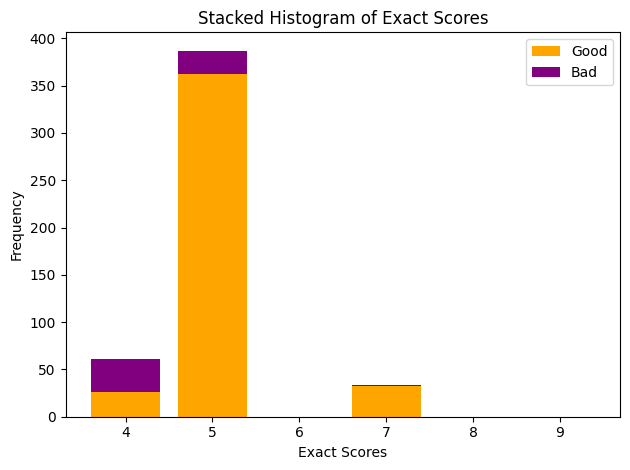

In [50]:
values = [4, 5, 6, 7, 8, 9]

# Example data (replace this with your actual data)
disc_bad = discrepancy_bad["recommendation_difference"]
disc_good = discrepancy_good["recommendation_difference"]

# Count occurrences of each score in each class
disc_bad_counts = [list(disc_bad).count(value) for value in values]
disc_good_counts = [list(disc_good).count(value) for value in values]

# Convert counts to arrays for stacking
disc_bad_counts = np.array(disc_bad_counts)
disc_good_counts = np.array(disc_good_counts)

# Create the bar chart
bar_width = 0.8
x = np.arange(len(values))  # Positions for the values

plt.bar(x, disc_good_counts, width=bar_width, label='Good', color='orange')
plt.bar(x, disc_bad_counts, width=bar_width, label='Bad', color='purple', bottom=disc_good_counts)

# Add labels, title, and legend
plt.xlabel('Exact Scores')
plt.ylabel('Frequency')
plt.title('Stacked Histogram of Exact Scores')
plt.xticks(ticks=x, labels=values)  # Replace x-axis with the exact score labels
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


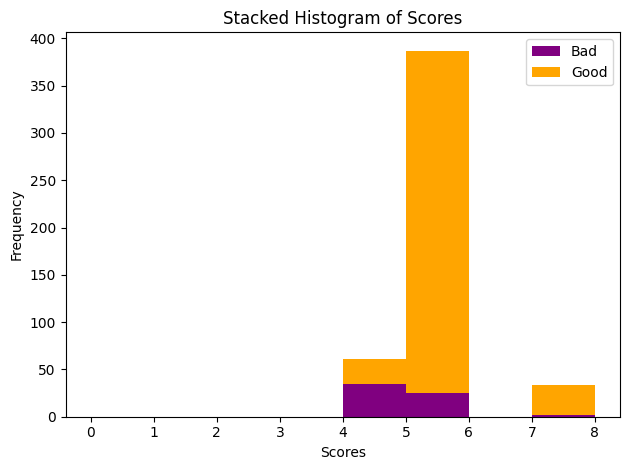

In [51]:
# Convert to numpy arrays for stacking
disc_bad = np.array(disc_bad)
disc_good = np.array(disc_good)

# Bar width
bar_width = 0.8
bins = np.arange(0, 9, 1)  # Bins from 0 to 10
# Create the bar chart
data = [disc_bad, disc_good]

plt.hist(data, bins=bins, stacked=True, label=['Bad', 'Good'], color=['purple', 'orange'])

plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Stacked Histogram of Scores')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
